In [279]:
import pandas as pd
import numpy as np
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print ('Install complete')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.




In [636]:
# Extracting all London postcode information from file
df_postcodes = pd.read_csv('London postcodes.csv')
# Selecting only relevant columns
df_postcodes = df_postcodes[['Postcode', 'In Use?','County','Postcode area', 'Postcode district','Population','Latitude','Longitude']]
df_postcodes.head()


C:\Users\rose.yin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (44,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Postcode,In Use?,County,Postcode area,Postcode district,Population,Latitude,Longitude
0,BR1 1AA,Yes,Greater London,BR,BR1,NaN,51.401546,0.015415
1,BR1 1AB,Yes,Greater London,BR,BR1,NaN,51.406333,0.015208
2,BR1 1AD,No,Greater London,BR,BR1,NaN,51.400057,0.016715
3,BR1 1AE,Yes,Greater London,BR,BR1,34.0,51.404543,0.014195
4,BR1 1AF,Yes,Greater London,BR,BR1,NaN,51.401392,0.014948


In [637]:
# remove rows where Postcode is not 'In Use' and remove duplicates by selecting whole of Greater London region
df_postcodes=df_postcodes[df_postcodes['In Use?']!='No']
df_postcodes=df_postcodes[df_postcodes['County'] == 'Greater London']
df_postcodes=df_postcodes.dropna() #excluding areas with no population
df_postcodes=df_postcodes[df_postcodes['Population'] > 10] #limit to postcodes with at least 10 population so district coordinates will be more centered around populated areas in the next step
print ('There are {} postcodes in the dataset'.format(df_postcodes.shape[0]))
df_postcodes.head()

There are 125222 postcodes in the dataset


,Postcode,In Use?,County,Postcode area,Postcode district,Population,Latitude,Longitude
3,BR1 1AE,Yes,Greater London,BR,BR1,34.0,51.404543,0.014195
13,BR1 1BQ,Yes,Greater London,BR,BR1,38.0,51.408058,0.015874
41,BR1 1EG,Yes,Greater London,BR,BR1,14.0,51.401684,0.015705
64,BR1 1HN,Yes,Greater London,BR,BR1,45.0,51.400390,0.015177
65,BR1 1HP,Yes,Greater London,BR,BR1,36.0,51.400808,0.014373


In [638]:
#grouping by postcode district, calculating the total population in each district and using average/mean coordinates from grouped postcodes
df_grouped_codes = df_postcodes.groupby(by = ['Postcode district', 'Postcode area','County'], as_index=False).agg({'Postcode' :'count', 'Population' : 'sum', 'Latitude' : 'mean', 'Longitude' :'mean'})                                                                                                   
print (df_grouped_codes.dtypes)     
df_grouped_codes   

Postcode district     object
Postcode area         object
County                object
Postcode               int64
Population           float64
Latitude             float64
Longitude            float64
dtype: object


,Postcode district,Postcode area,County,Postcode,Population,Latitude,Longitude
0,BR1,BR,Greater London,920,55392.0,51.413635,0.021312
1,BR2,BR,Greater London,818,44401.0,51.387739,0.021657
2,BR3,BR,Greater London,879,46548.0,51.404795,-0.029514
3,BR4,BR,Greater London,316,19184.0,51.375202,-0.007653
4,BR5,BR,Greater London,813,45773.0,51.391719,0.102623
...,...,...,...,...,...,...,...
268,WC2N,WC,Greater London,19,681.0,51.509330,-0.125344
269,WC2R,WC,Greater London,3,86.0,51.510974,-0.120196
270,WD23,WD,Greater London,2,32.0,51.631946,-0.334541
271,WD3,WD,Greater London,4,82.0,51.622985,-0.483460


In [284]:
address = 'London, UK'

geolocator = Nominatim(user_agent="London")
location = geolocator.geocode(address)
london_lat = location.latitude
london_lon = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(london_lat, london_lon))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [285]:
# create map of London using latitude and longitude values
map_london= folium.Map(location=[london_lat, london_lon], zoom_start=10)

# add markers to map
for lat, lng, postcode, district in zip(df_grouped_codes['Latitude'], df_grouped_codes['Longitude'], df_grouped_codes['Postcode district'], df_grouped_codes['Postcode area']):
    label = '{}, {}'.format(postcode, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [378]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

Text(0, 0.5, 'Number of postcode districts')

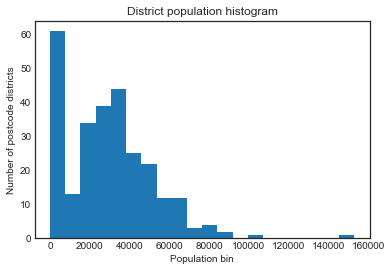

In [640]:
data = df_grouped_codes['Population'] #ploting the population distribution by districts to determine bins
plt.hist(data, bins=20)
plt.title('District population histogram')
plt.xlabel('Population bin')
plt.ylabel('Number of postcode districts')

In [425]:
bins = [0,5000,20000,60000,100000,200000] 
labels = [1,10,40,80,100]
df_grouped_codes['Population bins'] = pd.cut(df_grouped_codes['Population'],bins,labels=labels)
df_grouped_codes

,Postcode district,Postcode area,County,Postcode,Ward,Population,Latitude,Longitude,Address,Population bins
0,BR1,BR,Greater London,920,5,55392.0,51.413635,0.021312,"BR1, BR, London, UK",40
1,BR2,BR,Greater London,818,7,44401.0,51.387739,0.021657,"BR2, BR, London, UK",40
2,BR3,BR,Greater London,879,8,46548.0,51.404795,-0.029514,"BR3, BR, London, UK",40
3,BR4,BR,Greater London,316,3,19184.0,51.375202,-0.007653,"BR4, BR, London, UK",10
4,BR5,BR,Greater London,813,7,45773.0,51.391719,0.102623,"BR5, BR, London, UK",40
...,...,...,...,...,...,...,...,...,...,...
268,WC2N,WC,Greater London,19,1,681.0,51.509330,-0.125344,"WC2N, WC, London, UK",1
269,WC2R,WC,Greater London,3,1,86.0,51.510974,-0.120196,"WC2R, WC, London, UK",1
270,WD23,WD,Greater London,2,1,32.0,51.631946,-0.334541,"WD23, WD, London, UK",1
271,WD3,WD,Greater London,4,2,82.0,51.622985,-0.483460,"WD3, WD, London, UK",1


In [286]:

import requests

CLIENT_ID = 'XXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 60 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius (in meters)

Your credentails:
CLIENT_ID: DXJ5Y4WYQ3PGB0WG5YBSAJZWFHS30EBCCU2PWGDEJO1FIMN1
CLIENT_SECRET:HDJSZUUA3NDW4J4QA0FYZFMPCYKSL31ZGBE5YDXAWUIY10AD


In [287]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode district', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [288]:
# run the above function on each neighborhood and create a new dataframe called london_venues , spliting the runs into chunks to avoid timeouts
london_venues1 = getNearbyVenues(names=df_grouped_codes.loc[0:50, 'Postcode district'], latitudes=df_grouped_codes.loc[0:50,'Latitude'], longitudes=df_grouped_codes.loc[0:50,'Longitude'])

BR1
BR2
BR3
BR4
BR5
BR6
BR7
BR8
CM13
CR0
CR2
CR3
CR4
CR5
CR6
CR7
CR8
CR9
DA1
DA14
DA15
DA16
DA17
DA18
DA5
DA6
DA7
DA8
E1
E10
E11
E12
E13
E14
E15
E16
E17
E18
E1W
E2
E3
E4
E5
E6
E7
E8
E9
EC1A
EC1M
EC1N
EC1R


In [291]:
london_venues2 = getNearbyVenues(names=df_grouped_codes.loc[51:101, 'Postcode district'], latitudes=df_grouped_codes.loc[51:101,'Latitude'], longitudes=df_grouped_codes.loc[51:101,'Longitude'])

EC1V
EC1Y
EC2A
EC3N
EN1
EN2
EN3
EN4
EN5
EN6
EN8
HA0
HA1
HA2
HA3
HA4
HA5
HA6
HA7
HA8
HA9
IG1
IG11
IG2
IG3
IG4
IG5
IG6
IG7
IG8
IG9
KT1
KT17
KT18
KT19
KT2
KT22
KT3
KT4
KT5
KT6
KT8
KT9
N1
N10
N11
N12
N13
N14
N15
N16


In [294]:
# run the above function on each neighborhood and create a new dataframe called toronto_venues
london_venues3 = getNearbyVenues(names=df_grouped_codes.loc[102:153, 'Postcode district'], latitudes=df_grouped_codes.loc[102:153,'Latitude'], longitudes=df_grouped_codes.loc[102:153,'Longitude'])

N17
N18
N19
N2
N20
N21
N22
N3
N4
N5
N6
N7
N8
N9
NW1
NW10
NW11
NW2
NW3
NW4
NW5
NW6
NW7
NW8
NW9
RM1
RM10
RM11
RM12
RM13
RM14
RM15
RM2
RM3
RM4
RM5
RM6
RM7
RM8
RM9
SE1
SE10
SE11
SE12
SE13
SE14
SE15
SE16
SE17
SE18
SE19
SE2


In [295]:
# run the above function on each neighborhood and create a new dataframe called toronto_venues
london_venues4 = getNearbyVenues(names=df_grouped_codes.loc[154:205, 'Postcode district'], latitudes=df_grouped_codes.loc[154:205,'Latitude'], longitudes=df_grouped_codes.loc[154:205,'Longitude'])

SE20
SE21
SE22
SE23
SE24
SE25
SE26
SE27
SE28
SE3
SE4
SE5
SE6
SE7
SE8
SE9
SM1
SM2
SM3
SM4
SM5
SM6
SM7
SW10
SW11
SW12
SW13
SW14
SW15
SW16
SW17
SW18
SW19
SW1A
SW1E
SW1H
SW1P
SW1V
SW1W
SW1X
SW1Y
SW2
SW20
SW3
SW4
SW5
SW6
SW7
SW8
SW9
TN14
TN16


In [297]:
# run the above function on each neighborhood and create a new dataframe called toronto_venues
london_venues5 = getNearbyVenues(names=df_grouped_codes.loc[206:272, 'Postcode district'], latitudes=df_grouped_codes.loc[206:272,'Latitude'], longitudes=df_grouped_codes.loc[206:272,'Longitude'])

TW1
TW10
TW11
TW12
TW13
TW14
TW15
TW19
TW2
TW3
TW4
TW5
TW7
TW8
TW9
UB1
UB10
UB2
UB3
UB4
UB5
UB6
UB7
UB8
UB9
W10
W11
W12
W13
W14
W1B
W1C
W1D
W1F
W1G
W1H
W1J
W1K
W1S
W1T
W1U
W1W
W2
W3
W4
W5
W6
W7
W8
W9
WC1A
WC1B
WC1E
WC1H
WC1N
WC1R
WC1V
WC1X
WC2A
WC2B
WC2E
WC2H
WC2N
WC2R
WD23
WD3
WD6


In [298]:
print (london_venues1.shape) #checking data have been pulled into the new df
london_venues1

(2026, 7)


,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,51.413635,0.021312,Cinnamon Culture,51.414196,0.020883,Indian Restaurant
1,BR1,51.413635,0.021312,Barrel & Horn,51.405887,0.013701,Bar
2,BR1,51.413635,0.021312,Marks & Spencer,51.404017,0.015718,Department Store
3,BR1,51.413635,0.021312,Franco Manca,51.405992,0.016181,Pizza Place
4,BR1,51.413635,0.021312,Havet,51.406184,0.013522,Turkish Restaurant
...,...,...,...,...,...,...,...
2021,EC1R,51.525972,-0.108254,The Espresso Room,51.521910,-0.119775,Coffee Shop
2022,EC1R,51.525972,-0.108254,Sushi Show,51.535351,-0.103423,Sushi Restaurant
2023,EC1R,51.525972,-0.108254,Pistachio & Pickle Dairy,51.534827,-0.103868,Cheese Shop
2024,EC1R,51.525972,-0.108254,Scarfes Bar,51.517813,-0.118184,Hotel Bar


In [299]:
print (london_venues2.shape)
london_venues2

(2090, 7)


,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EC1V,51.526743,-0.098438,Jimmy And The Bee,51.526402,-0.100223,Coffee Shop
1,EC1V,51.526743,-0.098438,look mum no hands!,51.523915,-0.096897,Bike Shop
2,EC1V,51.526743,-0.098438,Yum Bowl,51.524183,-0.096071,Vietnamese Restaurant
3,EC1V,51.526743,-0.098438,Tanakatsu,51.530285,-0.101999,Japanese Restaurant
4,EC1V,51.526743,-0.098438,Victoria Miro Gallery,51.530207,-0.095084,Art Gallery
...,...,...,...,...,...,...,...
2085,N16,51.562359,-0.076620,Woodberry Wetlands,51.570673,-0.088856,Nature Preserve
2086,N16,51.562359,-0.076620,Hand of Glory,51.554595,-0.068260,Pub
2087,N16,51.562359,-0.076620,Stoke Newington Common,51.562155,-0.069595,Park
2088,N16,51.562359,-0.076620,Sodo Pizza Cafe - Clapton,51.563278,-0.058371,Pizza Place


In [300]:
print (london_venues3.shape)
london_venues3

(2400, 7)


,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,N17,51.598221,-0.07281,The Antwerp Arms,51.601775,-0.074762,Pub
1,N17,51.598221,-0.07281,San Marco,51.594256,-0.070077,Italian Restaurant
2,N17,51.598221,-0.07281,Tottenham Hotspur Stadium,51.604652,-0.067055,Soccer Stadium
3,N17,51.598221,-0.07281,The Beehive,51.592203,-0.069205,Pub
4,N17,51.598221,-0.07281,Spurs & NFL Shop,51.603046,-0.067581,Sporting Goods Shop
...,...,...,...,...,...,...,...
2395,SE2,51.489357,0.11569,Meghna Tandoori,51.485709,0.101681,Indian Restaurant
2396,SE2,51.489357,0.11569,Southmere Lake,51.499354,0.123837,Lake
2397,SE2,51.489357,0.11569,Ade's Cash & Carry,51.495040,0.098892,Food & Drink Shop
2398,SE2,51.489357,0.11569,Lakeside Complex,51.500789,0.123732,Pub


In [301]:
print (london_venues4.shape)
london_venues4

(2707, 7)


,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SE20,51.412019,-0.059692,Crystal Palace Dinosaur Park,51.417759,-0.067794,Sculpture Garden
1,SE20,51.412019,-0.059692,The Douglas Fir,51.414766,-0.070820,Pub
2,SE20,51.412019,-0.059692,Goldsmiths Arms,51.413500,-0.052114,Pub
3,SE20,51.412019,-0.059692,Alexandra Nurseries,51.417290,-0.050986,Garden Center
4,SE20,51.412019,-0.059692,Sicilian Art Pizzeria,51.411650,-0.048732,Pizza Place
...,...,...,...,...,...,...,...
2702,TN16,51.311274,0.034215,Tesco Express,51.310469,0.036693,Grocery Store
2703,TN16,51.311274,0.034215,Waitrose & Partners,51.309054,0.036832,Supermarket
2704,TN16,51.311274,0.034215,Cherry Lodge Golf Club,51.310242,0.054317,Golf Course
2705,TN16,51.311274,0.034215,Darwin Press,51.320783,0.020192,Print Shop


In [302]:
print (london_venues5.shape)
london_venues5

(3351, 7)


,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,TW1,51.450946,-0.324383,The White Swan,51.446906,-0.321350,Beer Garden
1,TW1,51.450946,-0.324383,York House Gardens,51.446944,-0.323826,Garden
2,TW1,51.450946,-0.324383,Pho Saigon,51.447905,-0.326161,Vietnamese Restaurant
3,TW1,51.450946,-0.324383,Moormead Park,51.452804,-0.325837,Park
4,TW1,51.450946,-0.324383,The Crown,51.451386,-0.318597,Gastropub
...,...,...,...,...,...,...,...
3346,WD6,51.642800,-0.256293,Dynasty,51.652044,-0.253956,Fish & Chips Shop
3347,WD6,51.642800,-0.256293,McColl's,51.652100,-0.254100,Convenience Store
3348,WD6,51.642800,-0.256293,Burger King,51.632328,-0.266359,Fast Food Restaurant
3349,WD6,51.642800,-0.256293,London Gateway Services (Welcome Break),51.631063,-0.264025,Rest Area


In [303]:
london_venues = london_venues1.append([london_venues2,london_venues3,london_venues4,london_venues5],ignore_index=True) # combined all london_venue df together into one df
london_venues

,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,51.413635,0.021312,Cinnamon Culture,51.414196,0.020883,Indian Restaurant
1,BR1,51.413635,0.021312,Barrel & Horn,51.405887,0.013701,Bar
2,BR1,51.413635,0.021312,Marks & Spencer,51.404017,0.015718,Department Store
3,BR1,51.413635,0.021312,Franco Manca,51.405992,0.016181,Pizza Place
4,BR1,51.413635,0.021312,Havet,51.406184,0.013522,Turkish Restaurant
...,...,...,...,...,...,...,...
12569,WD6,51.642800,-0.256293,Dynasty,51.652044,-0.253956,Fish & Chips Shop
12570,WD6,51.642800,-0.256293,McColl's,51.652100,-0.254100,Convenience Store
12571,WD6,51.642800,-0.256293,Burger King,51.632328,-0.266359,Fast Food Restaurant
12572,WD6,51.642800,-0.256293,London Gateway Services (Welcome Break),51.631063,-0.264025,Rest Area


In [304]:
london_venues.to_csv('london_venues2.csv') # save to local file to avoid rerun the above at later stage if needed to rerun the notebook

In [312]:
# Number of venues returned for each Neighborhood and unique categories that can be curated from all the returned values

print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

london_venues.groupby('Postcode district', as_index=False).count()

There are 389 uniques categories.


,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,57,57,57,57,57,57
1,BR2,38,38,38,38,38,38
2,BR3,59,59,59,59,59,59
3,BR4,28,28,28,28,28,28
4,BR5,23,23,23,23,23,23
...,...,...,...,...,...,...,...
268,WC2N,60,60,60,60,60,60
269,WC2R,60,60,60,60,60,60
270,WD23,9,9,9,9,9,9
271,WD3,7,7,7,7,7,7


In [311]:
# reviewing top venues across all districts
london_venues_categories = london_venues.groupby(by=['Venue Category']).count()
london_venues_categories.sort_values(by=['Postcode district'], ascending=False).head(10)

,Postcode district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Pub,955,955,955,955,955,955
Coffee Shop,816,816,816,816,816,816
Café,571,571,571,571,571,571
Grocery Store,509,509,509,509,509,509
Park,486,486,486,486,486,486
Hotel,388,388,388,388,388,388
Supermarket,330,330,330,330,330,330
Pizza Place,317,317,317,317,317,317
Italian Restaurant,284,284,284,284,284,284


In [426]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Postcode district'] = london_venues['Postcode district'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

print (london_onehot.shape)
london_onehot

(12574, 390)


,Postcode district,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,WD6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12570,WD6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12571,WD6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12572,WD6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [427]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

london_grouped = london_onehot.groupby('Postcode district').mean().reset_index()

print (london_grouped.shape)
london_grouped.head()

(273, 390)


,Postcode district,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,BR1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BR2,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BR3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BR4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BR5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [428]:
# A function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [641]:
# Create the new dataframe and display the top 10 venues for each postcode district.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postcode district'] = london_grouped['Postcode district']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BR1,Clothing Store,Pub,Coffee Shop,Café,Indian Restaurant,Park,Burger Joint,Hotel,Gym / Fitness Center,Pizza Place
1,BR2,Park,Grocery Store,Indian Restaurant,Pub,Gastropub,Coffee Shop,Pizza Place,American Restaurant,Electronics Store,Chinese Restaurant
2,BR3,Coffee Shop,Café,Park,Supermarket,Grocery Store,Pub,Tapas Restaurant,Gym / Fitness Center,Train Station,Tram Station
3,BR4,Grocery Store,Supermarket,Pub,Coffee Shop,Pizza Place,Steakhouse,Stationery Store,Gym / Fitness Center,Pet Store,Pharmacy
4,BR5,Park,Grocery Store,Clothing Store,Arts & Crafts Store,Bookstore,Sandwich Place,Bakery,Coffee Shop,Pet Store,Shopping Plaza


In [394]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [395]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  

Text(0, 0.5, 'Inertia')

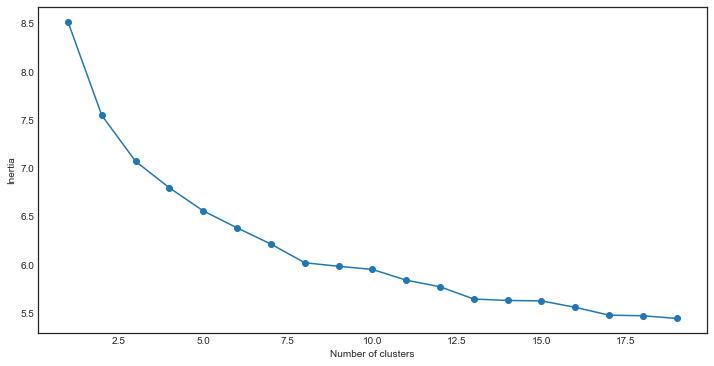

In [432]:
london_grouped_clustering = london_grouped.drop('Postcode district', 1)
# determining optimal k using the inertia attribute to identify the sum of squared distances (SSE) to the nearest cluster centre, up to k=20
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, random_state=0)
    #kmeans.fit(london_grouped_clustering)
    kmeans.fit(london_grouped_clustering, sample_weight = df_grouped_codes['Population bins'])
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [435]:
# Run k-means to cluster the neighborhood into 8 clusters using the Elbow Method

kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering, sample_weight = df_grouped_codes['Population bins'])

# check cluster labels generated for each row in the dataframe
kmeans.labels_.astype(int)


array([2, 1, 1, 7, 7, 5, 3, 6, 4, 1, 2, 1, 7, 5, 0, 7, 1, 3, 1, 6, 7, 1,
       7, 1, 1, 1, 1, 7, 2, 1, 1, 0, 1, 4, 4, 6, 3, 1, 2, 2, 3, 1, 3, 1,
       7, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 6, 1, 7, 3, 1, 4, 7, 0, 2, 0, 0,
       6, 1, 1, 1, 6, 2, 6, 1, 7, 1, 1, 6, 1, 1, 1, 3, 3, 1, 4, 7, 3, 1,
       6, 1, 1, 1, 3, 7, 3, 3, 7, 6, 1, 1, 3, 3, 1, 2, 3, 3, 2, 1, 3, 6,
       3, 3, 3, 3, 3, 6, 4, 6, 7, 1, 3, 6, 3, 3, 1, 4, 1, 2, 5, 1, 1, 1,
       1, 3, 1, 7, 3, 7, 7, 2, 7, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1,
       1, 3, 3, 3, 4, 1, 3, 1, 1, 3, 3, 3, 7, 1, 3, 6, 2, 2, 1, 6, 7, 7,
       0, 4, 3, 3, 3, 1, 3, 1, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 4,
       3, 4, 3, 4, 4, 4, 3, 7, 3, 3, 3, 1, 6, 6, 3, 2, 1, 6, 0, 0, 1, 3,
       4, 0, 1, 0, 6, 6, 7, 1, 1, 2, 3, 4, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 2, 4, 1, 3, 3, 3, 1, 4, 4, 4, 4, 2, 4, 2, 2, 4, 2,
       2, 4, 4, 4, 4, 4, 1, 7, 6])

In [437]:
# add clustering labels
neighborhoods_venues_sorted.insert(0 ,'Cluster Labels', kmeans.labels_.astype(int))


In [438]:
london_merged = df_grouped_codes[['Postcode district','Postcode area', 'Latitude','Longitude','Population bins','Population']]

# merge df_grouped with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
london_merged = pd.merge(london_merged, neighborhoods_venues_sorted, on='Postcode district')

london_merged

,Postcode district,Postcode area,Latitude,Longitude,Population bins,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,BR1,BR,51.413635,0.021312,40,55392.0,2,Clothing Store,Pub,Coffee Shop,Café,Indian Restaurant
1,BR2,BR,51.387739,0.021657,40,44401.0,1,Park,Grocery Store,Indian Restaurant,Pub,Gastropub
2,BR3,BR,51.404795,-0.029514,40,46548.0,1,Coffee Shop,Café,Park,Supermarket,Grocery Store
3,BR4,BR,51.375202,-0.007653,10,19184.0,7,Grocery Store,Supermarket,Pub,Coffee Shop,Pizza Place
4,BR5,BR,51.391719,0.102623,40,45773.0,7,Park,Grocery Store,Clothing Store,Arts & Crafts Store,Bookstore
...,...,...,...,...,...,...,...,...,...,...,...,...
268,WC2N,WC,51.509330,-0.125344,1,681.0,4,Plaza,Ice Cream Shop,Theater,Steakhouse,Art Gallery
269,WC2R,WC,51.510974,-0.120196,1,86.0,4,Theater,Hotel,Ice Cream Shop,Coffee Shop,Art Gallery
270,WD23,WD,51.631946,-0.334541,1,32.0,1,Garden Center,Bakery,Gastropub,Pub,Fish & Chips Shop
271,WD3,WD,51.622985,-0.483460,1,82.0,7,Fast Food Restaurant,Nature Preserve,Pub,Café,Turkish Restaurant


In [440]:
custer_size = london_merged.groupby('Cluster Labels')['Postcode district'].count() #counting number of districts in each cluster
custer_size

Cluster Labels
0    10
1    67
2    33
3    63
4    50
5     3
6    22
7    25
Name: Postcode district, dtype: int64

In [441]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[london_lat, london_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Postcode district'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [464]:
cluster_data = london_merged[['Postcode district','Cluster Labels']] #created second onehot encoding to for cluster labels
london_onehot2 = pd.merge(cluster_data, london_onehot, on='Postcode district').loc[:,'Cluster Labels':]
london_onehot2 

,Cluster Labels,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12570,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12571,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12572,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [466]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

london_grouped2 = london_onehot2.groupby('Cluster Labels').mean().reset_index()

print (london_grouped2.shape)
london_grouped2.head()

(8, 390)


,Cluster Labels,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0.000000,0.006410,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,1,0.000000,0.000395,0.000791,0.000395,0.00000,0.000000,0.004350,0.00000,0.000000,...,0.000000,0.000791,0.000791,0.001186,0.000000,0.000395,0.000000,0.000395,0.00000,0.000000
2,2,0.001062,0.000000,0.000531,0.000000,0.00478,0.002655,0.004249,0.00000,0.000000,...,0.005311,0.000531,0.014339,0.000000,0.000000,0.001062,0.000000,0.002124,0.00000,0.000000
3,3,0.000000,0.000299,0.001495,0.000000,0.00000,0.000000,0.002093,0.00000,0.000598,...,0.000299,0.000299,0.003589,0.005981,0.000299,0.000299,0.000299,0.004486,0.00000,0.000299
4,4,0.001751,0.000000,0.001401,0.000000,0.00000,0.000000,0.001050,0.00035,0.000350,...,0.000350,0.000000,0.009454,0.004902,0.000000,0.002801,0.000000,0.004552,0.00105,0.002451


In [473]:
# Create the new dataframe and display the top 10 venues for each clsuter.

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster Labels'] = london_grouped2['Cluster Labels']

for ind in np.arange(london_grouped2.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped2.iloc[ind, :], num_top_venues)

cluster_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Indian Restaurant,Grocery Store,Hotel,Fast Food Restaurant,Coffee Shop
1,1,Pub,Grocery Store,Coffee Shop,Supermarket,Park
2,2,Coffee Shop,Pub,Hotel,Café,Pizza Place
3,3,Pub,Café,Coffee Shop,Park,Italian Restaurant
4,4,Hotel,Café,Coffee Shop,Pub,Park
5,5,Platform,Supermarket,Pub,Grocery Store,Restaurant
6,6,Coffee Shop,Grocery Store,Supermarket,Park,Fast Food Restaurant
7,7,Grocery Store,Supermarket,Park,Coffee Shop,Café


In [495]:
# additional analysis on average population in each cluster and number of districts
cluster_data2 = london_merged[['Postcode district','Cluster Labels','Population','Postcode area']]
df_grouped_codes2 = df_grouped_codes[['Postcode district','Postcode']]
cluster_grouped = pd.merge(cluster_data2, df_grouped_codes2, on ='Postcode district')  
cluster_grouped = cluster_grouped.groupby(by = ['Cluster Labels'], as_index = False).agg(
{'Postcode':'sum', 'Population':'sum', 'Postcode district':'count', 'Postcode area': lambda x: pd.Series.mode(x)[0][0]})
cluster_grouped

,Cluster Labels,Postcode,Population,Postcode district,Postcode area
0,0,4477,345775.0,10,H
1,1,34648,2242716.0,67,S
2,2,11259,681439.0,33,E
3,3,33667,2163337.0,63,S
4,4,14545,865980.0,50,W
5,5,1823,106201.0,3,B
6,6,13241,861352.0,22,N
7,7,11562,783348.0,25,R


In [508]:
cluster_grouped['Avg pop per postcode'] = (cluster_grouped['Population'] / cluster_grouped['Postcode']).round(1)
cluster_grouped.sort_values(by='Population', ascending=False)
cluster_grouped = cluster_grouped.rename(columns={'Postcode':'No. of Postcodes','Postcode district':'No. of districts'})
cluster_grouped

,Cluster Labels,No. of Postcodes,Population,No. of districts,Postcode area,Avg pop per postcode
0,0,4477,345775.0,10,H,77.2
1,1,34648,2242716.0,67,S,64.7
2,2,11259,681439.0,33,E,60.5
3,3,33667,2163337.0,63,S,64.3
4,4,14545,865980.0,50,W,59.5
5,5,1823,106201.0,3,B,58.3
6,6,13241,861352.0,22,N,65.1
7,7,11562,783348.0,25,R,67.8


In [509]:
cluster_data = cluster_grouped[['Cluster Labels', 'No. of districts','Avg pop per postcode' ]]
cluster_data = pd.merge(cluster_data, cluster_venues_sorted, on='Cluster Labels')
cluster_data

,Cluster Labels,No. of districts,Avg pop per postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,10,77.2,Indian Restaurant,Grocery Store,Hotel,Fast Food Restaurant,Coffee Shop
1,1,67,64.7,Pub,Grocery Store,Coffee Shop,Supermarket,Park
2,2,33,60.5,Coffee Shop,Pub,Hotel,Café,Pizza Place
3,3,63,64.3,Pub,Café,Coffee Shop,Park,Italian Restaurant
4,4,50,59.5,Hotel,Café,Coffee Shop,Pub,Park
5,5,3,58.3,Platform,Supermarket,Pub,Grocery Store,Restaurant
6,6,22,65.1,Coffee Shop,Grocery Store,Supermarket,Park,Fast Food Restaurant
7,7,25,67.8,Grocery Store,Supermarket,Park,Coffee Shop,Café


(array([1., 1., 1., 1., 1., 0., 0., 1., 0., 2.]),
 array([ 3. ,  9.4, 15.8, 22.2, 28.6, 35. , 41.4, 47.8, 54.2, 60.6, 67. ]),
 <a list of 10 Patch objects>)

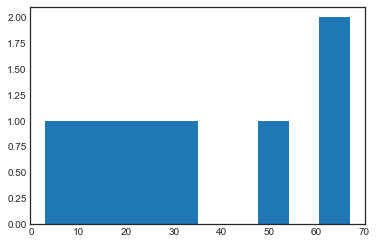

In [513]:
data = cluster_data['No. of districts']
plt.hist(data)

(array([2., 1., 0., 3., 0., 1., 0., 0., 0., 1.]),
 array([58.3 , 60.19, 62.08, 63.97, 65.86, 67.75, 69.64, 71.53, 73.42,
        75.31, 77.2 ]),
 <a list of 10 Patch objects>)

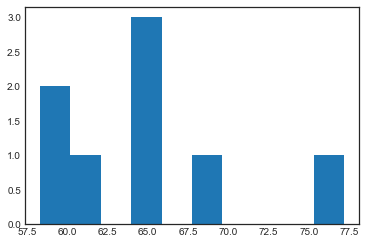

In [515]:
data = cluster_data['Avg pop per postcode']
plt.hist(data)

In [522]:
# extracting and adding house price information
avgPrice19 = pd.read_csv('avgPrice-county-GREATER_LONDON-by-pcDistrict-any-2019.csv')
avgPrice19 = avgPrice19.rename()
print(avgPrice19.dtypes)
avgPrice19

Unnamed: 0         object
Detached            int64
Sales               int64
Semi-det            int64
Sales.1             int64
Terraced            int64
Sales.2             int64
Flat/mais           int64
Sales.3             int64
Overall average     int64
Total sales         int64
dtype: object


,Unnamed: 0,Detached,Sales,Semi-det,Sales.1,Terraced,Sales.2,Flat/mais,Sales.3,Overall average,Total sales
0,BR1,938364,81,564206,119,401489,269,329418,194,475197,663
1,BR2,872935,122,557675,211,444082,153,331216,263,506304,749
2,BR3,980797,59,679700,116,536987,206,361486,297,523146,678
3,BR4,753619,35,593491,132,503479,48,213450,36,544098,251
4,BR5,677339,70,446640,278,334842,158,246505,86,415007,592
...,...,...,...,...,...,...,...,...,...,...,...
270,WC2N,0,0,0,0,0,0,1340389,9,1340389,9
271,WC2R,0,0,0,0,0,0,1725000,4,1725000,4
272,WD23,0,0,0,0,775000,1,0,0,775000,1
273,WD3,615000,1,0,0,0,0,304000,2,407667,3


In [538]:
#calculating the percentage sold houses that were flats in each district
avgPrice19 = avgPrice19.rename(columns = {'Unnamed: 0' : 'Postcode district' })
avgPrice19['% sold flats'] = ((avgPrice19['Sales.3'] / avgPrice19['Total sales'])*100).round(1)
avgPrice19


,Postcode district,Detached,Sales,Semi-det,Sales.1,Terraced,Sales.2,Flat/mais,Sales.3,Overall average,Total sales,Perc sold flats,% sold flats
0,BR1,938364,81,564206,119,401489,269,329418,194,475197,663,29.3,29.3
1,BR2,872935,122,557675,211,444082,153,331216,263,506304,749,35.1,35.1
2,BR3,980797,59,679700,116,536987,206,361486,297,523146,678,43.8,43.8
3,BR4,753619,35,593491,132,503479,48,213450,36,544098,251,14.3,14.3
4,BR5,677339,70,446640,278,334842,158,246505,86,415007,592,14.5,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,WC2N,0,0,0,0,0,0,1340389,9,1340389,9,100.0,100.0
271,WC2R,0,0,0,0,0,0,1725000,4,1725000,4,100.0,100.0
272,WD23,0,0,0,0,775000,1,0,0,775000,1,0.0,0.0
273,WD3,615000,1,0,0,0,0,304000,2,407667,3,66.7,66.7


In [541]:
avgPrice19.describe().round()

,Detached,Sales,Semi-det,Sales.1,Terraced,Sales.2,Flat/mais,Sales.3,Overall average,Total sales,Perc sold flats,% sold flats
count,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0
mean,961536.0,29.0,838453.0,90.0,863653.0,161.0,638063.0,300.0,810918.0,579.0,54.0,54.0
std,1745196.0,238.0,1454643.0,744.0,1445945.0,1330.0,892698.0,2481.0,911603.0,4786.0,30.0,30.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175000.0,1.0,0.0,0.0
25%,0.0,0.0,353316.0,2.0,371509.0,20.0,277936.0,38.0,429724.0,116.0,28.0,28.0
50%,599618.0,3.0,539573.0,27.0,507576.0,62.0,399773.0,96.0,554231.0,261.0,49.0,49.0
75%,1048848.0,16.0,823700.0,71.0,837874.0,122.0,622584.0,192.0,821056.0,404.0,83.0,83.0
max,19688939.0,3938.0,15000000.0,12344.0,17350000.0,22092.0,8783333.0,41187.0,8783333.0,79561.0,100.0,100.0


In [604]:
bins2 = [0,400000,600000,800000,1500000,10000000] #setting price bins based on eyeballing the split in overall average prices in descriptive stats above with added bands for £1.5m+ properties
labels2 = [1,2,3,4,5]
avgPrice19['Property priceband'] = pd.cut(avgPrice19['Overall average'],bins2,labels=labels2)
avgPrice19

,Postcode district,Detached,Sales,Semi-det,Sales.1,Terraced,Sales.2,Flat/mais,Sales.3,Overall average,Total sales,Perc sold flats,% sold flats,Property priceband
0,BR1,938364,81,564206,119,401489,269,329418,194,475197,663,29.3,29.3,2
1,BR2,872935,122,557675,211,444082,153,331216,263,506304,749,35.1,35.1,2
2,BR3,980797,59,679700,116,536987,206,361486,297,523146,678,43.8,43.8,2
3,BR4,753619,35,593491,132,503479,48,213450,36,544098,251,14.3,14.3,2
4,BR5,677339,70,446640,278,334842,158,246505,86,415007,592,14.5,14.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,WC2N,0,0,0,0,0,0,1340389,9,1340389,9,100.0,100.0,4
271,WC2R,0,0,0,0,0,0,1725000,4,1725000,4,100.0,100.0,5
272,WD23,0,0,0,0,775000,1,0,0,775000,1,0.0,0.0,3
273,WD3,615000,1,0,0,0,0,304000,2,407667,3,66.7,66.7,2


In [549]:
#getting postcode area name from Wikipedia
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml') # parse the HTML as a string
table=soup.find('table') 


In [550]:
column_names = ['Postalcode area','Postcode area name','Code formation']
areas = pd.DataFrame(columns = column_names)
areas.head()

,Postalcode area,Postcode area name,Code formation


In [553]:
# Search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        areas.loc[len(areas)] = row_data
areas

,Postalcode area,Postcode area name,Code formation
0,AB,Aberdeen,
1,AL,St Albans,
2,B,Birmingham,
3,BA,Bath,
4,BB,Blackburn,
...,...,...,...
237,WR,Worcester,
238,WS,Walsall,
239,WV,Wolverhampton,
240,YO,York,


In [565]:
areas['Postcode area name'] = areas['Postcode area name'].str.rstrip('[12345]')
areas.rename(columns={'Postalcode area':'Postcode area'}, inplace=True)
areas

,Postcode area,Postcode area name,Code formation
0,AB,Aberdeen,
1,AL,St Albans,
2,B,Birmingham,
3,BA,Bath,
4,BB,Blackburn,
...,...,...,...
237,WR,Worcester,
238,WS,Walsall,
239,WV,Wolverhampton,
240,YO,York,


In [605]:
#merging all relevant data for each district for enhanced labels

london_merged2 = london_merged[['Postcode district','Postcode area', 'Cluster Labels', 'Latitude','Longitude','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']]
areas2 = areas[['Postcode area','Postcode area name']]

london_merged2 = pd.merge(london_merged2, areas2, on ='Postcode area')

london_merged2 = london_merged2[['Postcode district','Postcode area name','Cluster Labels', 'Latitude','Longitude','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']]
properties = avgPrice19[['Postcode district', '% sold flats', 'Property priceband']]

london_merged2 = pd.merge(properties,london_merged2, on='Postcode district')
london_merged2

,Postcode district,% sold flats,Property priceband,Postcode area name,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,BR1,29.3,2,Bromley,2,51.413635,0.021312,Clothing Store,Pub,Coffee Shop
1,BR1,29.3,2,Bromley,2,51.413635,0.021312,Clothing Store,Pub,Coffee Shop
2,BR2,35.1,2,Bromley,1,51.387739,0.021657,Park,Grocery Store,Indian Restaurant
3,BR2,35.1,2,Bromley,1,51.387739,0.021657,Park,Grocery Store,Indian Restaurant
4,BR3,43.8,2,Bromley,1,51.404795,-0.029514,Coffee Shop,Café,Park
...,...,...,...,...,...,...,...,...,...,...
521,WC2R,100.0,5,West Central London,4,51.510974,-0.120196,Theater,Hotel,Ice Cream Shop
522,WD23,0.0,3,Watford,1,51.631946,-0.334541,Garden Center,Bakery,Gastropub
523,WD23,0.0,3,Watford,1,51.631946,-0.334541,Garden Center,Bakery,Gastropub
524,WD3,66.7,2,Watford,7,51.622985,-0.483460,Fast Food Restaurant,Nature Preserve,Pub


In [642]:
map_clusters2 = folium.Map(location=[london_lat, london_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers for e
for idx in range(len(london_merged2)):
    html_label = ''
    
    lat = london_merged2['Latitude'].loc[idx]
    lng = london_merged2['Longitude'].loc[idx]
    poi = london_merged2['Postcode district'].loc[idx]
    area = london_merged2['Postcode area name'].loc[idx]
    cluster = london_merged2['Cluster Labels'].loc[idx]
    priceband = london_merged2['Property priceband'].loc[idx]
    flats = london_merged2['% sold flats'].loc[idx]
    
    html_label = '<h6>' +  ' Cluster:' + str(cluster) + '</h4><h5><b> District: </b>' + str(poi) +', ' + area + '</h5><h5><b> Priceband: </b>' + str(priceband) + ', ' + str(flats) +'% flats' + ' </h5><h5><b> Top 3 Venues: </b></h5><h5><ol>'
    
    
    for col in range(7, 10):
        html_label += '<li>' + london_merged2.iloc[idx, col]
    
    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
    

map_clusters2
    